## H2O-3 Regression Tutorial

[**1B. Introduction to Machine Learning with H2O-3 - Regression**](https://training.h2o.ai/products/1b-introduction-to-machine-learning-with-h2o-3-regression)に沿ったチュートリアル

[**H2O 3 - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html)  
[**Python - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/index.html)

注意：[XGBoost(H2OXGBoostEstimator)はWindows上で動作しない](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#limitations)

#### 目次
- [Initial Setup](#InitialSetup)
    - パッケージのインポート
    - H2Oクラスターの開始
    - データのロード
- [Start Experiment](#StartExperiment)
    - データの確認
    - 学習(train)/検証(valid)/テスト(test)データセットへの分割
    - 利用変数の定義
- [Build an XGBoost Model](#BuildXGBoostModel)
    - XGBoostモデルの作成(デフォルト設定)と学習
    - オリジナルのXGBoostとの比較（to do）
    - 学習結果の確認
    - train/validデータにおける精度確認
- [Tune the XGBoost Model with H2O GridSearch](#TuneXGBoostModelGridSearch)
    - XXX
- [Test Set Performance](#TestSetPerformance)
    - XXX
    - H2Oクラスターの停止
- [H2O-3の特徴](#H2O-3の特徴)

***

<a id='InitialSetup'></a>
### Initial Setup

In [1]:
#Import H2O and other libraries that will be used in this tutorial 
import h2o
import matplotlib as plt
%matplotlib inline

#Import the Estimators
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OXGBoostEstimator

#Import h2o grid search 
import h2o.grid 
from h2o.grid.grid_search import H2OGridSearch

In [2]:
#> h2oパッケージのバージョン確認
print(h2o.__version__)

3.30.1.2


In [3]:
#> H2Oクラスターの開始
h2o.init(url='http://localhost:54321')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_261"; Java(TM) SE Runtime Environment (build 1.8.0_261-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from /home/ec2-user/anaconda3/envs/h2o_3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_pyx_b82
  JVM stdout: /tmp/tmp_pyx_b82/h2o_ec2_user_started_from_python.out
  JVM stderr: /tmp/tmp_pyx_b82/h2o_ec2_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_ec2_user_5sqbg7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.677 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [4]:
#> データのロード
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


連邦住宅金融抵当公庫(Freddie Mac)が提供する約20年間(1999/1-2018/12)の住宅ローン(Fixed-Rate Mortgages)の履歴データ。金利をターゲット変数として回帰の説明に使用する。  
  
[Data Reference](http://www.freddiemac.com/research/datasets/sf_loanlevel_dataset.page)  
[変数等データ詳細に関して](http://www.freddiemac.com/fmac-resources/research/pdf/user_guide.pdf)  
  
行数:500,137、列数:27（約80MB）

***

<a id='StartExperiment'></a>
### Start Experiment

In [5]:
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
669,200206,N,202901,nan,0,1,O,80,33,162000,80,7.12,R,N,FRM,WV,SF,26100,F199Q1000004,P,320,2,Other sellers,Other servicers,TRUE,FALSE
732,199904,N,202903,17140,0,1,O,25,10,53000,25,6.5,R,N,FRM,OH,SF,45200,F199Q1000005,N,360,1,Other sellers,Other servicers,TRUE,FALSE
679,200208,N,202902,15940,30,1,O,91,48,133000,91,6.75,R,N,FRM,OH,SF,44700,F199Q1000007,P,319,1,Other sellers,Other servicers,TRUE,FALSE
721,200209,N,202902,38060,0,1,O,39,13,174000,39,6.625,T,N,FRM,AZ,SF,85200,F199Q1000013,N,318,2,Other sellers,Other servicers,TRUE,FALSE
618,200210,N,202902,10420,25,1,O,85,24,122000,85,6.375,R,N,FRM,OH,SF,44200,F199Q1000015,N,317,2,Other sellers,Other servicers,TRUE,FALSE
738,200211,N,202903,10420,0,1,O,73,44,218000,73,6,R,N,FRM,OH,SF,44300,F199Q1000016,P,317,2,Other sellers,Other servicers,TRUE,FALSE
761,200211,N,202904,nan,0,1,O,73,31,138000,73,6.375,R,N,FRM,SC,PU,29500,F199Q1000017,P,318,2,Other sellers,Other servicers,TRUE,FALSE
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
760,200211,N,202903,33340,0,1,O,63,30,79000,63,6.125,R,N,FRM,WI,SF,53000,F199Q1000019,N,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE


ターゲット変数として利用する「金利(ORIGINAL_INTEREST_RATE)」の分布の確認

In [6]:
loan_level["ORIGINAL_INTEREST_RATE"].describe()

Rows:500137
Cols:1




,ORIGINAL_INTEREST_RATE
type,real
mins,4.625
mean,7.182686863799322
maxs,11.5
sigma,0.5799408623980744
zeros,0
missing,0
0,7.12
1,6.5
2,6.75


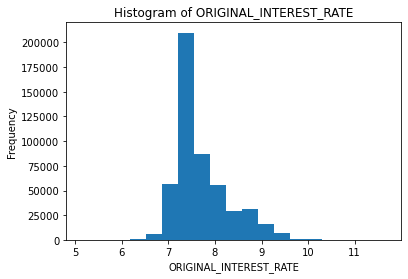

In [7]:
#> ヒストグラムによる分布の確認
loan_level["ORIGINAL_INTEREST_RATE"].hist()

In [8]:
#> 学習/検証/テストデータセットへの分割（学習 : 検証 : テスト = 70% : 15% : 15%）
train, valid, test = loan_level.split_frame([0.7, 0.15], seed=42)
print("＜train/valid/testのデータ数＞")
print( "train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows ))

＜train/valid/testのデータ数＞
train:350268 valid:74971 test:74898


In [9]:
#> ターゲット変数、特徴量の定義
y = "ORIGINAL_INTEREST_RATE"

ignore = ["ORIGINAL_INTEREST_RATE", 
          "FIRST_PAYMENT_DATE", 
          "MATURITY_DATE", 
          "MORTGAGE_INSURANCE_PERCENTAGE", 
          "PREPAYMENT_PENALTY_MORTGAGE_FLAG", 
          "LOAN_SEQUENCE_NUMBER", 
          "PREPAID", 
          "DELINQUENT", 
          "PRODUCT_TYPE"] 

x = list(set(train.names) - set(ignore))
print(x)

['PROPERTY_STATE', 'METROPOLITAN_STATISTICAL_AREA', 'PROPERTY_TYPE', 'ORIGINAL_COMBINED_LOAN_TO_VALUE', 'ORIGINAL_UPB', 'NUMBER_OF_UNITS', 'SELLER_NAME', 'ORIGINAL_DEBT_TO_INCOME_RATIO', 'CHANNEL', 'ORIGINAL_LOAN_TO_VALUE', 'FIRST_TIME_HOMEBUYER_FLAG', 'NUMBER_OF_BORROWERS', 'CREDIT_SCORE', 'POSTAL_CODE', 'ORIGINAL_LOAN_TERM', 'SERVICER_NAME', 'LOAN_PURPOSE', 'OCCUPANCY_STATUS']


In [10]:
loan_level[x].describe()

Rows:500137
Cols:18




,PROPERTY_STATE,METROPOLITAN_STATISTICAL_AREA,PROPERTY_TYPE,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_UPB,NUMBER_OF_UNITS,SELLER_NAME,ORIGINAL_DEBT_TO_INCOME_RATIO,CHANNEL,ORIGINAL_LOAN_TO_VALUE,FIRST_TIME_HOMEBUYER_FLAG,NUMBER_OF_BORROWERS,CREDIT_SCORE,POSTAL_CODE,ORIGINAL_LOAN_TERM,SERVICER_NAME,LOAN_PURPOSE,OCCUPANCY_STATUS
type,enum,int,enum,int,int,int,enum,int,enum,int,enum,int,int,int,int,enum,enum,enum
mins,,10180.0,,6.0,8000.0,1.0,,1.0,,6.0,,1.0,300.0,600.0,301.0,,,
mean,,30777.82473929504,,76.0535707144633,136493.48478516805,1.0288902574110184,,32.91754051870545,,75.71071405720141,,1.6302946648262713,712.5362124215468,55490.8571382869,359.8554696013299,,,
maxs,,49740.0,,180.0,578000.0,4.0,,65.0,,100.0,,2.0,839.0,99900.0,362.0,,,
sigma,,11333.401144164478,,15.139986048512673,60968.74306564561,0.21839057355939082,,11.111799994455248,,14.937717088968643,,0.48272535304031594,54.79126197408813,29505.38225880303,1.9082507104186504,,,
zeros,,0,,0,0,0,,0,,0,,0,0,0,0,,,
missing,0,70149,0,13,0,3,0,14929,0,9,0,247,2711,31,0,0,0,0
0,WV,nan,SF,80.0,162000.0,1.0,Other sellers,33.0,R,80.0,N,2.0,669.0,26100.0,320.0,Other servicers,P,O
1,OH,17140.0,SF,25.0,53000.0,1.0,Other sellers,10.0,R,25.0,N,1.0,732.0,45200.0,360.0,Other servicers,N,O
2,OH,15940.0,SF,91.0,133000.0,1.0,Other sellers,48.0,R,91.0,N,1.0,679.0,44700.0,319.0,Other servicers,P,O


***

<a id='BuildXGBoostModel'></a>
### Build an XGBoost Model

[**XGBoost - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#xgboost)  
[**H2OXGBoostEstimator - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oxgboostestimator)
  
H2O XGBoostはH2Oクラスター上でオリジナルのXGBoost動作させるようビルドされたもの。カテゴリ変数の自動Encodingといった処理も含まれている。

オリジナルのXGBoostの[ドキュメンテーション](https://xgboost.readthedocs.io/en/latest/#)

In [11]:
xgb = H2OXGBoostEstimator(seed=42, 
                          model_id='XGBoost', 
                          nfolds=0, 
                          keep_cross_validation_predictions=False)

%time xgb.train(x=x, y=y, training_frame=train, validation_frame=valid)    # 注：Windowsではサポートされていない

xgboost Model Build progress: |███████████████████████████████████████████| 100%
CPU times: user 317 ms, sys: 33.3 ms, total: 351 ms
Wall time: 27.5 s


- train時にvalidation_frameを指定してホールドアウト法になるので、nfolds=0、keep_cross_validation_predictions=False(それぞれデフォルト)としている

In [12]:
xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost


Model Summary: 


,number_of_trees
,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.17744636323081306
RMSE: 0.4212438287154045
MAE: 0.30712844420662655
RMSLE: 0.04987056256391179
Mean Residual Deviance: 0.17744636323081306

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.18013989282125126
RMSE: 0.4244289019626859
MAE: 0.3108204587914598
RMSLE: 0.0503052982338251
Mean Residual Deviance: 0.18013989282125126

Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2020-09-15 07:20:33,0.075 sec,0.0,6.7088631,6.6836794,45.0088439,6.7047501,6.6798046,44.9536733
,2020-09-15 07:20:36,2.466 sec,1.0,4.7104733,4.6786978,22.1885588,4.7073544,4.6757908,22.1591850
,2020-09-15 07:20:36,3.230 sec,2.0,3.3168272,3.2752196,11.0013425,3.3139314,3.2725993,10.9821415
,2020-09-15 07:20:37,3.812 sec,3.0,2.3488131,2.2927392,5.5169229,2.3462673,2.2904798,5.5049702
,2020-09-15 07:20:38,4.403 sec,4.0,1.6810353,1.6051706,2.8258796,1.6786024,1.6031085,2.8177062
,2020-09-15 07:20:38,5.025 sec,5.0,1.2265317,1.1245445,1.5043799,1.2244424,1.1227758,1.4992593
,2020-09-15 07:20:42,9.203 sec,15.0,0.4526525,0.3278245,0.2048943,0.4522328,0.3289853,0.2045145
,2020-09-15 07:20:46,13.244 sec,24.0,0.4384250,0.3211508,0.1922165,0.4389171,0.3229872,0.1926482
,2020-09-15 07:20:51,17.759 sec,34.0,0.4303815,0.3147750,0.1852282,0.4316122,0.3173036,0.1862891
,2020-09-15 07:20:57,24.150 sec,48.0,0.4219223,0.3077781,0.1780184,0.4248844,0.3113217,0.1805268



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
"SELLER_NAME.NORWESTMORTGAGE,INC",25657.9960938,1.0,0.2391252
OCCUPANCY_STATUS.I,7086.1391602,0.2761766,0.0660408
ORIGINAL_UPB,6440.5112305,0.2510138,0.0600237
ORIGINAL_LOAN_TO_VALUE,5813.7905273,0.2265879,0.0541829
LOAN_PURPOSE.P,4025.8632812,0.1569048,0.0375199
---,---,---,---
PROPERTY_STATE.OK,0.8522186,0.0000332,0.0000079
PROPERTY_STATE.ME,0.5269806,0.0000205,0.0000049
PROPERTY_STATE.MT,0.5000267,0.0000195,0.0000047
PROPERTY_STATE.KS,0.0765716,0.0000030,0.0000007


In [13]:
#> 推定したモデルの設定やハイパーパラメータの確認
xgb.actual_params

{'model_id': 'XGBoost',
 'training_frame': 'py_10_sid_bceb',
 'validation_frame': 'py_11_sid_bceb',
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'fold_assignment': None,
 'fold_column': None,
 'response_column': 'ORIGINAL_INTEREST_RATE',
 'ignored_columns': ['MATURITY_DATE',
  'FIRST_PAYMENT_DATE',
  'DELINQUENT',
  'PRODUCT_TYPE',
  'PREPAYMENT_PENALTY_MORTGAGE_FLAG',
  'LOAN_SEQUENCE_NUMBER',
  'PREPAID',
  'MORTGAGE_INSURANCE_PERCENTAGE'],
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'stopping_rounds': 0,
 'stopping_metric': None,
 'stopping_tolerance': 0.001,
 'max_runtime_secs': 0.0,
 'seed': 42,
 'distribution': 'gaussian',
 'tweedie_power': 1.5,
 'categorical_encoding': 'OneHotInternal',
 'quiet_mode': True,
 'checkpoint': None,
 'export_checkpoints_dir': None,
 'ntrees': 50,
 'max_depth': 6,
 'min_rows': 1.0,
 'm

- 各内容に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#defining-an-xgboost-model)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oxgboostestimator)
- デフォルト設定の確認の場合 `xgb.params`, `xgb.default_params`
- [オリジナルのXGBoostのハイパーパラメーターに関するドキュメント](https://xgboost.readthedocs.io/en/latest/parameter.html#)

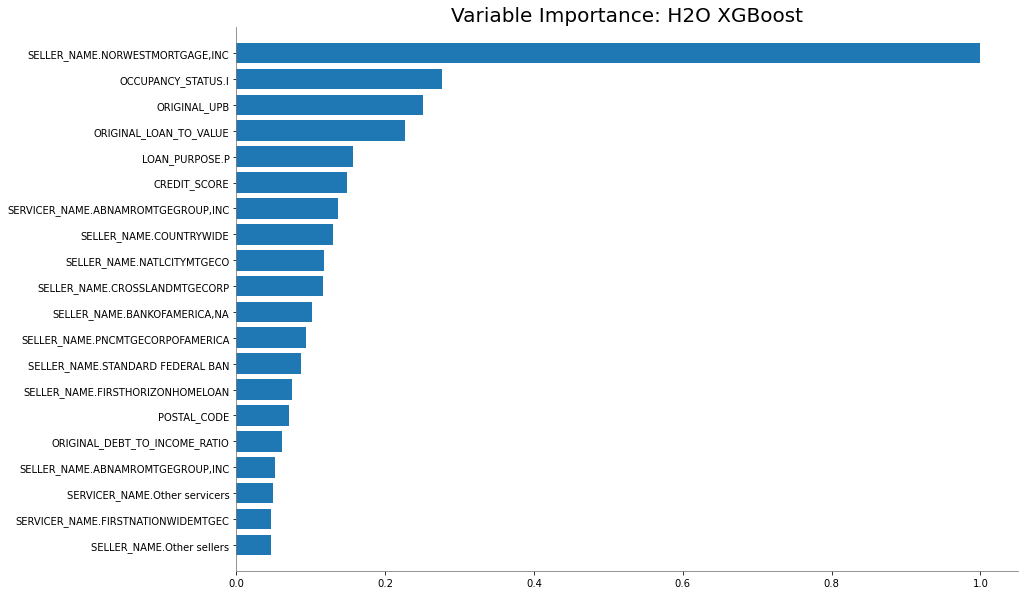

In [14]:
#> 変数重要度の表示
xgb.varimp_plot(20)

- 値自体を取得する場合 `xgb.varimp()`
- H2ORandomForestEstimatorやH2OGradientBoostingEstimatorと異なり、カテゴリ変数はone-hot encodingされた形式で表示

In [15]:
#> validデータに対する予測を実施
xgb_def_pred = xgb.predict(valid)
xgb_def_pred.head(5)

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict
7.20097
6.87724
7.0235
7.25526
7.02648


In [16]:
#> 実測値との比較
xgb_def_pred.cbind(valid['ORIGINAL_INTEREST_RATE'])

predict,ORIGINAL_INTEREST_RATE
7.20097,5.875
6.87724,6.75
7.0235,7.75
7.25526,6.625
7.02648,6.75
7.38137,7
6.8168,7
7.40214,7
7.06643,7.25
7.00728,7


In [17]:
#> validデータでの結果の取得
default_xgb_per = xgb.model_performance(valid)

In [18]:
print('RMSE on train data: ', xgb.rmse())
print('RMSE on valid data: ', default_xgb_per.rmse())

RMSE on train data:  0.4212438287154045
RMSE on valid data:  0.4244289019626859


***

<a id='BuildDeepLearningModel'></a>
### Build a Deep Learning Model

[**Deep Learning (Neural Networks) - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html)  
[**H2ODeepLearningEstimator - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2odeeplearningestimator)
  
H2O-3では通常のFeedforward Neural Networkのみサポート（CNNやRNNの実装はない）

In [19]:
dl = H2ODeepLearningEstimator(seed=42, 
                              model_id='DL',
                              nfolds= 0, 
                              keep_cross_validation_predictions = False)

%time dl.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 1.46 s, sys: 117 ms, total: 1.57 s
Wall time: 6min 1s


In [20]:
dl

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DL


Status of Neuron Layers: predicting ORIGINAL_INTEREST_RATE, regression, gaussian distribution, Quadratic loss, 73,601 weights/biases, 880.4 KB, 3,505,265 training samples, mini-batch size 1


,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,165,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0554799,0.2137462,0.0,-0.0186659,0.1892132,-0.0814594,0.2958229
,3,200,Rectifier,0.0,0.0,0.0,0.0504873,0.0515644,0.0,-0.0487905,0.1326573,-0.2468700,0.5911310
,4,1,Linear,,0.0,0.0,0.0013629,0.0011417,0.0,0.0074794,0.0866947,1.2335939,0.0000000




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.19309338243511368
RMSE: 0.43942392110024425
MAE: 0.3232758649464976
RMSLE: 0.052248091660660925
Mean Residual Deviance: 0.19309338243511368

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.19547157579350896
RMSE: 0.4421216753264976
MAE: 0.32602246553842124
RMSLE: 0.05249309269475424
Mean Residual Deviance: 0.19547157579350896

Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
,2020-09-15 07:21:02,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2020-09-15 07:21:08,10.708 sec,1561 obs/sec,0.0228197,1,7993.0,0.5312050,0.2821788,0.3991446,0.1411118,0.5332077,0.2843104,0.3996868,0.1484763
,2020-09-15 07:22:01,1 min 3.567 sec,7211 obs/sec,1.0892060,47,381514.0,0.5373093,0.2887013,0.4117756,0.1212587,0.5363096,0.2876280,0.4122002,0.1385400
,2020-09-15 07:22:52,1 min 54.324 sec,8870 obs/sec,2.5025067,108,876548.0,0.4967532,0.2467637,0.3584243,0.2489073,0.4944530,0.2444838,0.3577137,0.2677589
,2020-09-15 07:23:41,2 min 43.436 sec,9749 obs/sec,3.9824506,172,1394925.0,0.4664814,0.2176049,0.3355960,0.3376601,0.4677403,0.2187810,0.3379100,0.3447402
,2020-09-15 07:24:29,3 min 32.169 sec,10188 obs/sec,5.4402572,235,1905548.0,0.4706263,0.2214891,0.3546952,0.3258374,0.4721864,0.2229600,0.3576890,0.3322237
,2020-09-15 07:25:17,4 min 20.250 sec,10566 obs/sec,6.9461041,300,2432998.0,0.4405997,0.1941281,0.3262213,0.4091182,0.4430808,0.1963206,0.3283321,0.4120101
,2020-09-15 07:26:06,5 min 9.057 sec,10855 obs/sec,8.5001028,367,2977314.0,0.4394239,0.1930934,0.3232759,0.4122676,0.4421217,0.1954716,0.3260225,0.4145530
,2020-09-15 07:26:53,5 min 56.003 sec,11080 obs/sec,10.0073801,432,3505265.0,0.4582141,0.2099601,0.3503260,0.3609290,0.4620276,0.2134695,0.3544031,0.3606483
,2020-09-15 07:26:58,6 min 0.828 sec,11080 obs/sec,10.0073801,432,3505265.0,0.4394239,0.1930934,0.3232759,0.4122676,0.4421217,0.1954716,0.3260225,0.4145530



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
SELLER_NAME.WELLSFARGOHOMEMORTGA,1.0,1.0,0.0126944
"SELLER_NAME.ABNAMROMTGEGROUP,INC",0.9382787,0.9382787,0.0119109
SELLER_NAME.CROSSLANDMTGECORP,0.8789046,0.8789046,0.0111572
SELLER_NAME.BISHOPSGATERESIDENTI,0.8727375,0.8727375,0.0110789
"SELLER_NAME.NORWESTMORTGAGE,INC",0.8668389,0.8668389,0.0110040
---,---,---,---
PROPERTY_TYPE.missing(NA),0.0,0.0,0.0
CHANNEL.missing(NA),0.0,0.0,0.0
LOAN_PURPOSE.missing(NA),0.0,0.0,0.0
OCCUPANCY_STATUS.missing(NA),0.0,0.0,0.0


In [21]:
#> 推定したモデルの設定やハイパーパラメータの確認
dl.actual_params

{'model_id': 'DL',
 'training_frame': 'py_10_sid_bceb',
 'validation_frame': 'py_11_sid_bceb',
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'fold_assignment': None,
 'fold_column': None,
 'response_column': 'ORIGINAL_INTEREST_RATE',
 'ignored_columns': ['MATURITY_DATE',
  'FIRST_PAYMENT_DATE',
  'DELINQUENT',
  'PRODUCT_TYPE',
  'PREPAYMENT_PENALTY_MORTGAGE_FLAG',
  'LOAN_SEQUENCE_NUMBER',
  'PREPAID',
  'MORTGAGE_INSURANCE_PERCENTAGE'],
 'ignore_const_cols': True,
 'score_each_iteration': False,
 'weights_column': None,
 'offset_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_hit_ratio_k': 0,
 'checkpoint': None,
 'pretrained_autoencoder': None,
 'overwrite_with_best_model': True,
 'use_all_factor_levels': True,
 'standardize': True,
 'activation': 'Rectifier',
 'hidden': [200, 200],
 '

- 各内容に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html#defining-a-deep-learning-model)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2odeeplearningestimator)
- デフォルト設定の確認の場合 `dl.params`, `dl.default_params`

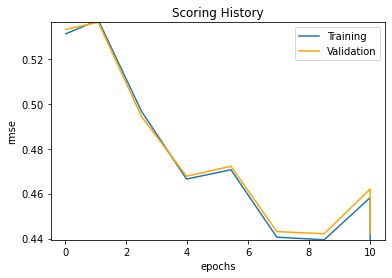

In [22]:
#> 学習の履歴の表示
dl.plot()

In [23]:
print("epochs = ", dl.params['epochs'])

epochs =  {'default': 10.0, 'actual': 10.0, 'input': 10.0}


- デフォルトのエポック数は10

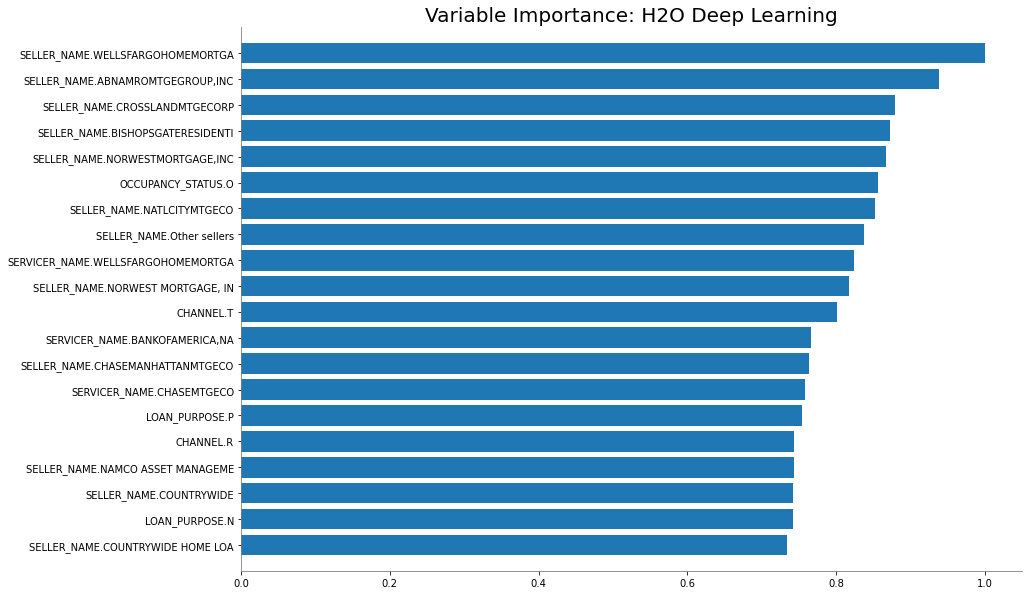

In [28]:
#> 変数重要度の表示
dl.varimp_plot(20)

- 変数重要度は"Gedeon method"により算出（[FAQ](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html#faq)に記載）

In [24]:
#> validデータでの結果の取得
default_dl_per = dl.model_performance(valid)

In [25]:
print('RMSE on train data: ', dl.rmse())
print('RMSE on valid data: ', default_dl_per.rmse())

RMSE on train data:  0.43942392110024425
RMSE on valid data:  0.4421216753264976


その他NN特有の仕様に関する[FAQ](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html#faq)

***

<a id='TuneXGBoostModelGridSearch'></a>
### Tune the XGBoost Model with H2O GridSearch

[**Gred Search - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#grid-hyperparameter-search)  
[**H2OGridSearch - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogridsearch)

XGBoostにおいて、max_depthは最も重要なハイパーパラメーターの一つ。デフォルト設定では6。max_depthの値が大きいと学習に時間がかかるので、まずはグリッドサーチでmax_depthを決定した後、その他のハイパーパラメーターにランダムサーチを実施する

In [26]:
xgb = H2OXGBoostEstimator(model_id='xgb', ntrees=100,
                          stopping_rounds=5,  # default
                          stopping_tolerance=1e-4,  # default
                          stopping_metric = "rmse",  # default
                          seed=42)

hyper_params = {'max_depth' : [5,7,9,10,12,13,15,20]}

grid_id = 'depth_grid'

search_criteria = { "strategy":"Cartesian"}

xgb_grid = H2OGridSearch(model=xgb, 
                         hyper_params=hyper_params,
                         grid_id=grid_id,
                         search_criteria=search_criteria)

%time xgb_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%
CPU times: user 2.66 s, sys: 130 ms, total: 2.79 s
Wall time: 14min 36s


ハイパーパラメータに関して
- max_depth - [ドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/max_depth.html)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.max_depth)

[H2OGridSearchにおいてXGBoostがサポートするハイパーパラメーター一覧](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#xgboost-hyperparameters)

In [29]:
#> 探索結果の表示（RMSE基準）
xgb_grid.get_grid(sort_by='rmse',decreasing=False)


Hyper-Parameter Search Summary: ordered by increasing rmse


,max_depth,model_ids,rmse
,9,depth_grid_model_3,0.4134846
,10,depth_grid_model_4,0.4137581
,7,depth_grid_model_2,0.4147110
,12,depth_grid_model_5,0.4164160
,13,depth_grid_model_6,0.4203949
,5,depth_grid_model_1,0.4204568
,15,depth_grid_model_7,0.4248075
,20,depth_grid_model_8,0.4379013


max_depth=9がベストとなった。その設定の下、その他のハイパーパラメーターをランダムサーチしてみる

In [31]:
#> その他のハイパーパラメーターに対しランダムサーチを実施

xgb = H2OXGBoostEstimator(model_id='xgb_grid', max_depth=9, ntrees=100, 
                          stopping_rounds=5,
                          stopping_tolerance=1e-4,
                          stopping_metric = "rmse",
                          seed=42)

hyper_params = {'reg_alpha' : [x*0.01 for x in range(0, 101)],
                'reg_lambda' : [x*0.01 for x in range(0, 101)],
                'learn_rate' : [x*0.01 for x in range(1, 101)],
                'distribution' : ['poisson', 'tweedie', 'gaussian', 'gamma'],
                'booster' : ['gbtree', 'gblinear', 'dart']}

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 450,   # 探索のストップ基準：最大時間(7分半)
                        'max_models': 50,   # 探索のストップ基準：作成する最大のモデル数
                        'seed' : 42}

xgb_grid = H2OGridSearch(xgb, 
                         hyper_params,
                         grid_id='random_grid',
                         search_criteria=search_criteria_tune)

%time xgb_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%
CPU times: user 1.91 s, sys: 98.2 ms, total: 2.01 s
Wall time: 7min 33s


各ハイパーパラメータに関して
- reg_alpha - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.reg_alpha)（L1正則化の重み）
- reg_lambda - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.reg_lambda)（L2正則化の重み）
- learn_rate - [ドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/learn_rate.html)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.learn_rate)
- distribution - [ドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/distribution.html)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.distribution)
- booster - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.booster)

[H2OGridSearchにおいてXGBoostがサポートするハイパーパラメーター一覧](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#xgboost-hyperparameters)  
[オリジナルのXGBoostのハイパーパラメーターに関するドキュメント](https://xgboost.readthedocs.io/en/latest/parameter.html#)

In [33]:
#> 探索結果の表示（RMSE基準）
xgb_grid.get_grid(sort_by='rmse', decreasing=False)


Hyper-Parameter Search Summary: ordered by increasing rmse


,booster,distribution,learn_rate,reg_alpha,reg_lambda,model_ids,rmse
,dart,gaussian,0.61,0.67,0.34,random_grid_model_3,0.4248153
,gbtree,gaussian,0.6,0.36,0.17,random_grid_model_2,0.4273411
,gbtree,gaussian,0.8200000,0.69,0.88,random_grid_model_1,0.4384176
,dart,gaussian,0.89,0.5,0.63,random_grid_model_5,0.4393239
,gblinear,gaussian,0.08,0.68,0.92,random_grid_model_4,0.6939840


[dart booster](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html)を採用し、rate_dropとskip_dropをランダムサーチを実施し、精度が向上するか確認

In [34]:
xgb = H2OXGBoostEstimator(model_id='xgb', 
                          max_depth=9, 
                          ntrees=100, 
                          distribution='gaussian',
                          reg_alpha= 0.67,
                          reg_lambda= 0.34,
                          learn_rate= 0.61,
                          stopping_rounds=5,  # default
                          stopping_tolerance=1e-4,  # default
                          stopping_metric = "rmse",  # default
                          seed=42,
                          booster = 'dart',
                          normalize_type='forest',
                          one_drop=False,
                          sample_type='uniform')

hyper_params = { 'rate_drop' : [x*0.025 for x in range(0, 21)], #start from 0 to 0.5 in increments of 0.025
                 'skip_drop' : [x*0.025 for x in range(20, 41)] #start from 0.5 to 1 in increments of 0.025
                }

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 300,  # 5 min  
                        'max_models': 40,   # build no more than 40 models
                        'seed' : 42}

xgb_grid = H2OGridSearch(xgb, hyper_params,
                         grid_id='dart_booster_grid',
                         search_criteria=search_criteria_tune)

%time xgb_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%
CPU times: user 1.38 s, sys: 57.5 ms, total: 1.44 s
Wall time: 5min 3s


各ハイパーパラメータに関して
- normalize_type - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.normalize_type)（dartのみ）
- one_drop - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.one_drop)（dartのみ）
- sample_type - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.sample_type)（dartのみ）
- rate_drop - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.rate_drop)（dartのみ）
- skip_drop - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.skip_drop)（dartのみ）
  
[dart boosterに関するオリジナルのXGBoostのドキュメント](https://xgboost.readthedocs.io/en/latest/parameter.html#additional-parameters-for-dart-booster-booster-dart)

In [35]:
xgb_grid.get_grid(sort_by='rmse',decreasing=False)


Hyper-Parameter Search Summary: ordered by increasing rmse


,rate_drop,skip_drop,model_ids,rmse
,0.275,0.9,dart_booster_grid_model_2,0.4162070
,0.225,0.95,dart_booster_grid_model_1,0.4187967


In [37]:
xgb_grid


Hyper-Parameter Search Summary: ordered by increasing residual_deviance


,rate_drop,skip_drop,model_ids,residual_deviance
,0.275,0.9,dart_booster_grid_model_2,0.1732282
,0.225,0.95,dart_booster_grid_model_1,0.1753907


In [36]:
#> Mean Residual Deviance基準で最適なモデルを取得
best_xgb_model = xgb_grid.models[0] 
best_xgb_model

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  dart_booster_grid_model_2


Model Summary: 


,number_of_trees
,80.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.1480685319069398
RMSE: 0.38479674102952044
MAE: 0.279033765052327
RMSLE: 0.045614212666119584
Mean Residual Deviance: 0.1480685319069398

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.17322824292132674
RMSE: 0.4162069712550797
MAE: 0.30259255115280925
RMSLE: 0.049337902723038264
Mean Residual Deviance: 0.17322824292132674

Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2020-09-15 08:27:06,3 min 2.881 sec,0.0,6.7088631,6.6836794,45.0088439,6.7047501,6.6798046,44.9536733
,2020-09-15 08:27:07,3 min 4.193 sec,1.0,2.6561735,2.6069449,7.0552576,2.6536824,2.6047770,7.0420302
,2020-09-15 08:27:08,3 min 4.956 sec,2.0,1.1248013,1.0187216,1.2651779,1.1229032,1.0170359,1.2609117
,2020-09-15 08:27:09,3 min 5.793 sec,3.0,0.6125743,0.4525943,0.3752472,0.6115991,0.4514537,0.3740534
,2020-09-15 08:27:09,3 min 6.644 sec,4.0,0.4836919,0.3363244,0.2339579,0.4836126,0.3372060,0.2338811
,2020-09-15 08:27:14,3 min 11.069 sec,10.0,0.4289158,0.3133417,0.1839687,0.4338691,0.3181515,0.1882424
,2020-09-15 08:27:18,3 min 15.184 sec,15.0,0.4206298,0.3065666,0.1769294,0.4278328,0.3128159,0.1830409
,2020-09-15 08:27:24,3 min 20.952 sec,21.0,0.4129572,0.3002513,0.1705336,0.4234790,0.3093437,0.1793345
,2020-09-15 08:27:32,3 min 28.759 sec,28.0,0.4034008,0.2923724,0.1627322,0.4199245,0.3061051,0.1763366
,2020-09-15 08:27:42,3 min 38.766 sec,36.0,0.3986505,0.2887370,0.1589222,0.4185507,0.3048728,0.1751847



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
"SELLER_NAME.NORWESTMORTGAGE,INC",32304.2656250,1.0,0.2335608
OCCUPANCY_STATUS.I,8938.4013672,0.2766942,0.0646249
ORIGINAL_UPB,8290.3828125,0.2566343,0.0599397
ORIGINAL_LOAN_TO_VALUE,7418.7294922,0.2296517,0.0536376
CREDIT_SCORE,6557.4257812,0.2029895,0.0474104
---,---,---,---
PROPERTY_TYPE.CP,4.4970784,0.0001392,0.0000325
PROPERTY_STATE.AK,3.2365997,0.0001002,0.0000234
PROPERTY_STATE.DC,3.1666882,0.0000980,0.0000229
PROPERTY_TYPE.,2.3219380,0.0000719,0.0000168


- RMSE基準で最適なモデルを取得する場合 `xgb_grid.get_grid(sort_by='rmse', decreasing=False).models[0]`

In [41]:
#> validデータに対する結果取得
tuned_xgb_per = best_xgb_model.model_performance(valid)

In [42]:
#> [Build an XGBoost Model]で学習したモデルとランダムサーチした結果をvalidデータで比較
print("Default XGB RMSE: %.4f \nTuned XGB RMSE:%.4f" % (default_xgb_per.rmse(), tuned_xgb_per.rmse()))

Default XGB RMSE: 0.4244 
Tuned XGB RMSE:0.4162


In [43]:
print("Default XGB MAE: %.4f \nTuned XGB MAE:%.4f" % (default_xgb_per.mae(), tuned_xgb_per.mae()))

Default XGB MAE: 0.3108 
Tuned XGB MAE:0.3026


<a id='TuneDeepLearningModelGridSearch'></a>
### Tune the Deep Learning with H2O GridSearch

[**Gred Search - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#grid-hyperparameter-search)  
[**H2OGridSearch - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogridsearch)

In [27]:
#> H2Oクラスターの終了
#h2o.cluster().shutdown()